In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_ptiles_comp
from viz.fit import plot_all_losses

import yaml

In [14]:
from os.path import exists, join, splitext

In [ ]:
import pickle as pkl
with open('../../misc/predictions/final_mumbai_20.pickle', 'rb') as handle:
    PD = pkl.load(handle)


In [15]:
save = False

In [16]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [24]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.usetex': True,
    'font.size': 18,
    'font.family': 'Palatino',
})

In [25]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [26]:
import pickle as pkl
with open('../../misc/predictions/mcmc_total.pickle', 'rb') as handle:
    PD_t = pkl.load(handle)
with open('../../misc/predictions/mcmc_active.pickle', 'rb') as handle:
    PD_a = pkl.load(handle)
with open('../../misc/predictions/mcmc_recovered.pickle', 'rb') as handle:
    PD_r = pkl.load(handle)
with open('../../misc/predictions/mcmc_deceased.pickle', 'rb') as handle:
    PD_d = pkl.load(handle)

total
active
recovered
deceased


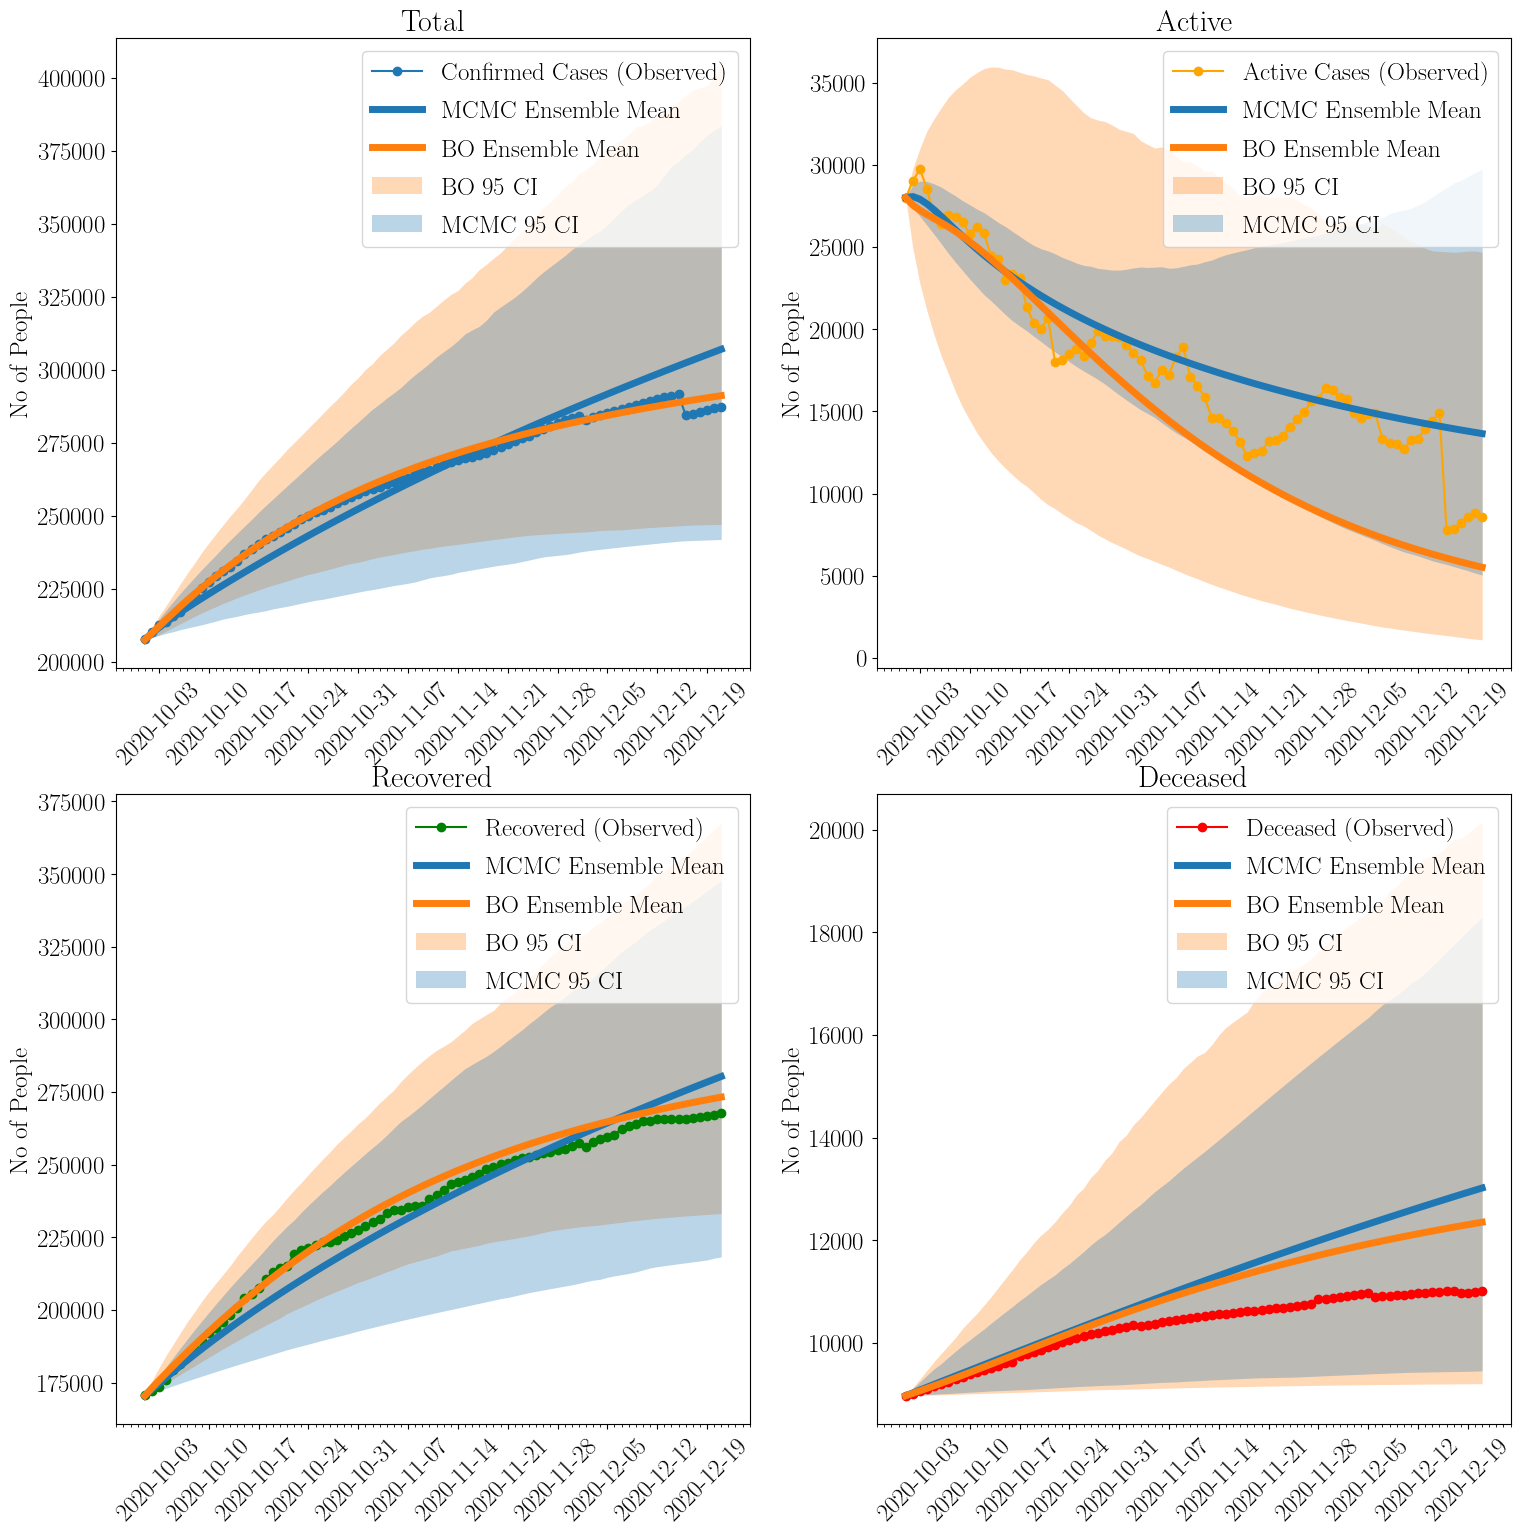

In [27]:
fig,axs = plt.subplots(figsize=(18,18),nrows=2,ncols=2) 
plot_ptiles_comp(PD_t, compartment=config['forecast']['plot_ptiles_for_columns'][0],ax=axs.flat[0])
plot_ptiles_comp(PD_a, compartment=config['forecast']['plot_ptiles_for_columns'][1],ax=axs.flat[1])
plot_ptiles_comp(PD_r, compartment=config['forecast']['plot_ptiles_for_columns'][2],ax=axs.flat[2])
plot_ptiles_comp(PD_d, compartment=config['forecast']['plot_ptiles_for_columns'][3],ax=axs.flat[3])
plt.show()
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/CI.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)

In [29]:
which_compartments = ['total', 'active', 'recovered', 'deceased','agg']

In [30]:
df_compiled = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['df_loss']['train']
        df['agg'] = df.mean()
        df_compiled[model].append(df)
        

In [31]:
import pandas as pd
from viz.fit import comp_bar

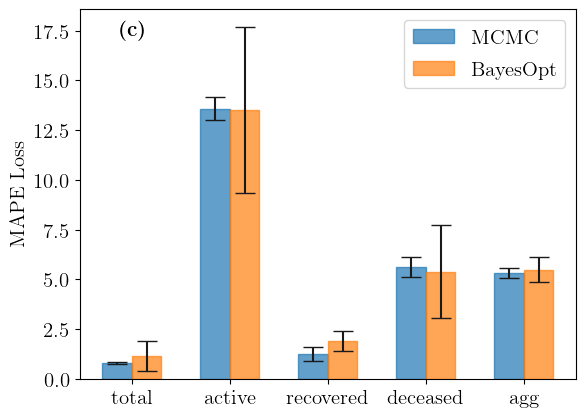

In [32]:
fig,ax = plt.subplots()
comp_bar(PD,'ensemble',ax)

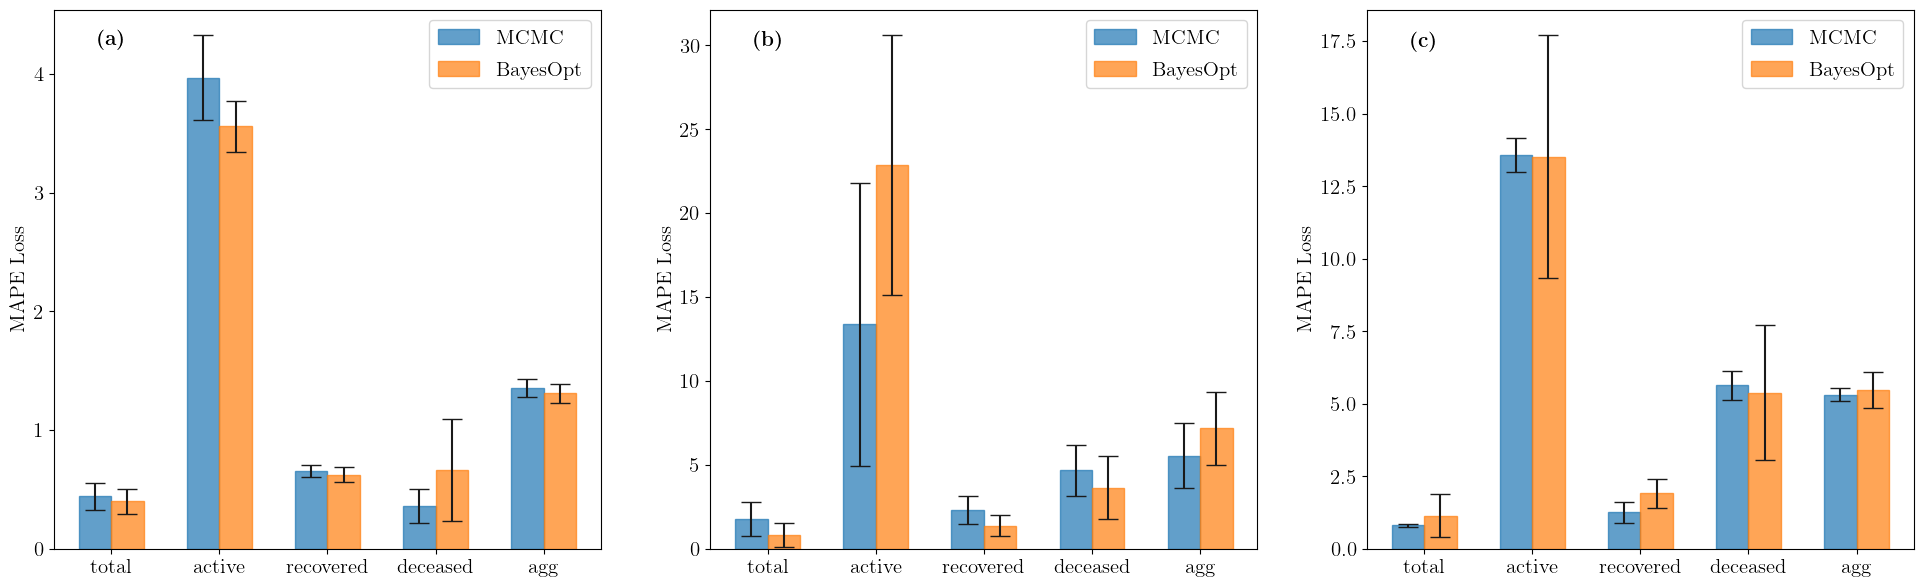

In [33]:
fig,axs = plt.subplots(figsize=(24,7),nrows=1,ncols=3)
comp_bar(PD,'train',axs.flat[0])
comp_bar(PD,'test',axs.flat[1])
comp_bar(PD,'ensemble',axs.flat[2])
# fig.suptitle('Comparision of Fitting with BO and MCMC', fontsize=16)
if save:
    fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/Bar_plots.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)

## Percentile Loss

In [34]:
df_compiled_perc_loss = {"MCMC":[],"BO":[]}
percentiles = []

for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = {}
        percentiles = list(model_dict['uncertainty_forecasts'].keys())
        for perc,perc_dict in model_dict['uncertainty_forecasts'].items():
            df[perc] = perc_dict['df_loss_perc']['test']['total']
        df_compiled_perc_loss[model].append(df)

In [35]:
stats_perc_MCMC = pd.DataFrame(df_compiled_perc_loss['MCMC']).describe().loc[['mean','std']]
stats_perc_BO = pd.DataFrame(df_compiled_perc_loss['BO']).describe().loc[['mean','std']]

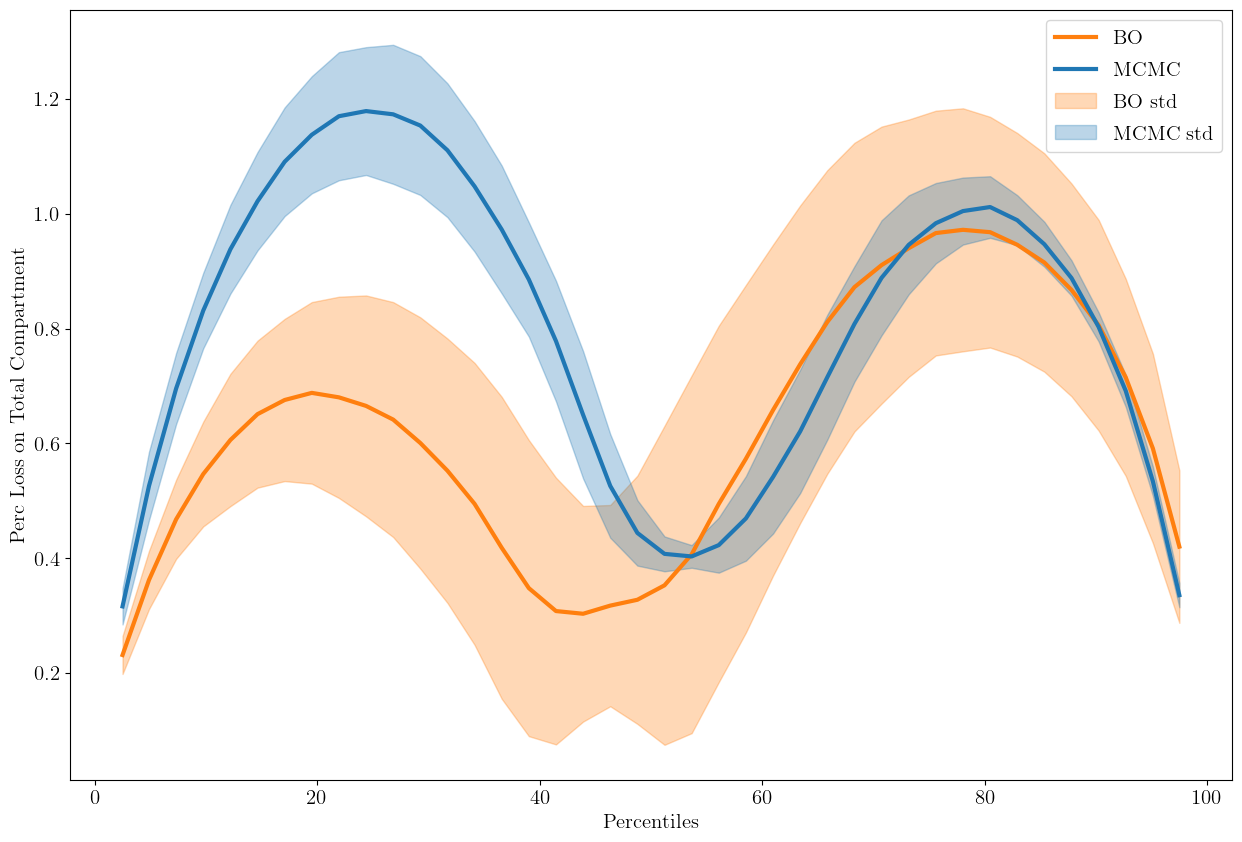

In [36]:
import matplotlib as mpl
barWidth = 0.3

fig = plt.figure(figsize=(15,10))
# plt.errorbar(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'orange',label='BO',yerr =list(stats_perc_BO.loc['std'].values) ,elinewidth =3,capthick =3,barsabove = True)
# plt.errorbar(list(stats_perc_MCMC.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'blue',label = 'MCMC',yerr = list(stats_perc_MCMC.loc['std'].values),elinewidth =3,capthick =3,barsabove = True)
plt.plot(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'tab:orange',label='BO',lw =3)
plt.plot(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'tab:blue',label='MCMC',lw =3)

plt.fill_between(list(stats_perc_BO.loc['mean'].keys()),np.array(stats_perc_BO.loc['mean'].values)+np.array(stats_perc_BO.loc['std'].values) ,np.array(stats_perc_BO.loc['mean'].values)-np.array(stats_perc_BO.loc['std'].values),alpha =0.3,color = 'tab:orange',label = 'BO std')
plt.fill_between(list(stats_perc_MCMC.loc['mean'].keys()),np.array(stats_perc_MCMC.loc['mean'].values)+np.array(stats_perc_MCMC.loc['std'].values) ,np.array(stats_perc_MCMC.loc['mean'].values)-np.array(stats_perc_MCMC.loc['std'].values),alpha =0.3,color = 'tab:blue',label = 'MCMC std')              

# general layout
plt.ylabel('Perc Loss on Total Compartment')
plt.xlabel('Percentiles')
# plt.title('Day Wise Percentile Loss Values on Test for 1 November - 21 November')
plt.legend()
if save:
    fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/perc_loss_mcmc.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)


In [19]:
from viz.fit import plot_comp_density_plots,plot_histogram

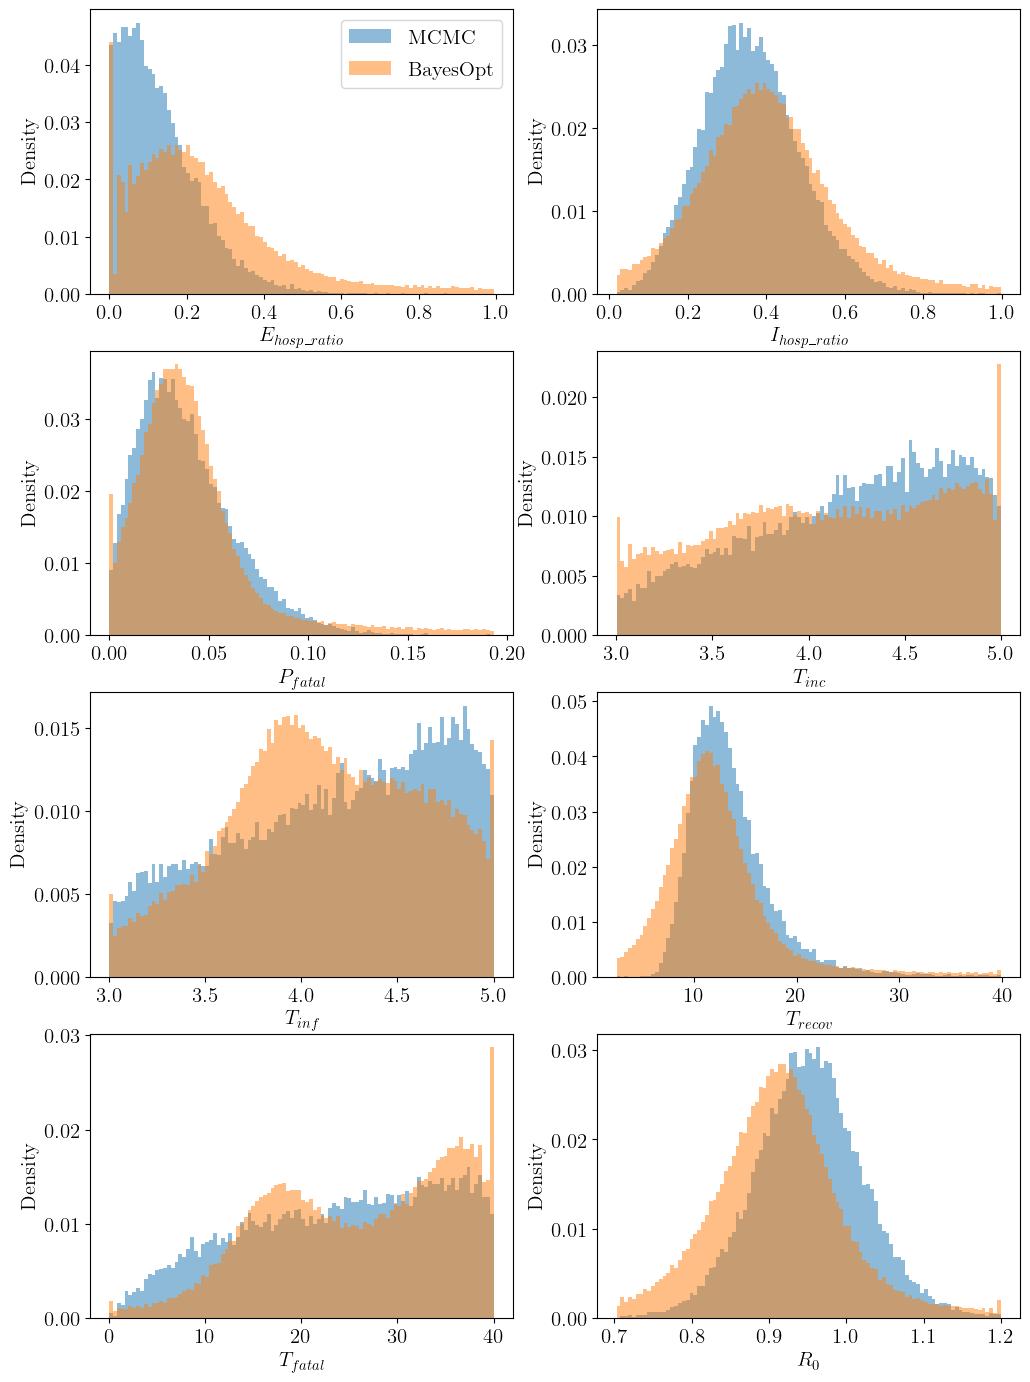

In [20]:
figs, axs = plt.subplots(4,2,figsize = [12,17])
X= {}
plot_comp_density_plots(PD,figs,axs)
if save:
    figs.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/hist.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)